In [109]:
import pandas as pd
import numpy as np
import re
import nltk, spacy
import scipy.sparse as sp
from collections import Counter
from SimpleNLP import Tokenizer
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

# Estadistica con palabras  

Al construir el vocabulario en una colección de documentos, se realizan  normalizaciones que nos permiten agrupar patrones comunes. aún cuando identificar y contabilizar los terminos en el vocabulario es útil para tareas simples, como computar estadisticas de uso o realizar búsquedas por palabras claves. Sin embargo, también se podría querer realizar tareas en la que la `importancia` dentro del documento o la colección de las palabras sea o no relevante. Por ejemplo no es deseado que un email  sea catalogado como spam solo una palabra común en ese tipo de mensajes.

Si se puede medir la importacia de los términos, también seá posible tan positivo o negativo es un tweet con respecto de otro en la mis colección. Los ejemplos anteriores los podemos modelar mediente el uso de la frecuencia con que aparece un termino un documento con respecto al resto en la colección. 

En las siguientes secciones ampliaremos el espacio vectorial binario mediate el uso de frecuencias, paa convertir las palabras en VSM de números reales. El objetivo es proporcionar un representación que capture la importacia de cada término.  

Las representaciones que revisaremos son:

- **Bolsa de palabras**. Representación basada en la fecuencia de  las palabras
- **Bolsa de $n$-gramas** Conteo de bigramas, trigramas, etc
- **TF-IDF** Permiten medir la importancia de las palabras.

**TF-IDF** es el acrónimo para `Term Frecuency Inverse Document Frecuency`. TF se refiere a la frecuencia de un  termino en un documento, mientras que IDF  implica que TF será pesado en base a la frecuencia de ese mismo termino en toda la colección (una división).

### Bolsa de palabras

En las sesiones previas ya hemos utilizado bolsas de palabras binarias, es decir solo decidimos si una palabra aparece o no en un documentos. A esta tipo en particular le denominamos **one-hot econding**. Con esa representación simple es posible crear un indice que permita hacer consultas simplmente utilizando operaciones `OR` y `AND`. Nuestro modulo `SimpleNLP` ya implementa ese tipo de datos.

Ahora procederemos a hacer una representación donde se considere el número de veces que aprece cada término en el documento. Es decir una bolsa de palabras que consideré la frecuencia.

In [4]:
# Carguemos nuevamente nuestro conjunto de tweets de humor
train_df=pd.read_csv('data/humor/train_english.tgz', compression='gzip',usecols=['is_humor','text'], encoding='unicode_escape')
test_df=pd.read_csv('data/humor/dev_english.csv',usecols=['is_humor','text']) 
train_df=train_df.dropna().astype({'is_humor': 'int32'})
test_df=test_df.dropna().astype({'is_humor': 'int32'})

In [5]:
# Generemos nuestro vocabulario
from SimpleNLP import Tokenizer
# Entrenamos el modelo
tk=Tokenizer(derivador='stem')
tk.fit(train_df.text)

In [6]:
tk.vocabulario_index

array(['tennesse', 'were', 'the', ..., 'slot', 'pervas', 'aspirin'],
      dtype='<U77')

In [7]:
# Revisemos el tweet 50
tweet,label=train_df.iloc[100]
tweet_vector=tk.transform([tweet])

In [8]:
# Podemos ver su forma vectorial, texto, etiqueta y dimension
print(f"Vector:{tweet_vector.toarray()}\nTexto:{tweet}\nEtiqueta:{label}\nDimension{tweet_vector.shape}")

Vector:[[0 0 1 ... 0 0 0]]
Texto:Last night my wife and I watched 2 hours of cooking shows, before she hugged me and went to bed. I'm pretty sure I'm in the friend zone.
Etiqueta:1
Dimension(1, 11065)


In [9]:
# Elementos diferentes de 0 (VSM binario)
print(tweet_vector)

  (0, 2)	1
  (0, 20)	1
  (0, 22)	1
  (0, 29)	1
  (0, 51)	1
  (0, 59)	1
  (0, 63)	1
  (0, 65)	1
  (0, 75)	1
  (0, 76)	1
  (0, 130)	1
  (0, 352)	1
  (0, 373)	1
  (0, 409)	1
  (0, 515)	1
  (0, 550)	1
  (0, 619)	1
  (0, 770)	1
  (0, 804)	1
  (0, 920)	1
  (0, 921)	1
  (0, 922)	1
  (0, 923)	1
  (0, 924)	1
  (0, 925)	1
  (0, 926)	1


In [10]:
Counter(tk.tokenize(tweet)).most_common(5)

[('and', 2), ('im', 2), ('last', 1), ('night', 1), ('my', 1)]

Uno de los clasificadores que mejor funciona con este tipo de representaciones dispersas es SVM con kernel lineal. A continuación lo usaremos para tenerlo como referencia para comparar ambas versiones (Binario/Frecuencia). 

In [11]:
from sklearn.metrics import f1_score as f1, accuracy_score as acc
from sklearn.svm import LinearSVC
clf = LinearSVC()

In [12]:
# Transformamos los textos al VSM 
train=tk.transform(train_df.text)
test=tk.transform(test_df.text)

In [13]:
# Entrenamos el clasificador
clf.fit(train,train_df.is_humor)

/home/job/python3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [14]:
y=test_df.is_humor
yp=clf.predict(test)
print("F-Score: {} Accuracy: {} ".format(f1(y,yp),acc(y,yp)))

F-Score: 0.8416988416988417 Accuracy: 0.795 


In [15]:
# Podemos generar un mapa {"Palabra: count"} primero tokenizando
tweet_tokens=tk.tokenize(tweet)
Counter(tweet_tokens)

Counter({'and': 2,
         'im': 2,
         'last': 1,
         'night': 1,
         'my': 1,
         'wife': 1,
         'i': 1,
         'watch': 1,
         '2': 1,
         'hour': 1,
         'of': 1,
         'cook': 1,
         'show': 1,
         'befor': 1,
         'she': 1,
         'hug': 1,
         'me': 1,
         'went': 1,
         'to': 1,
         'bed': 1,
         'pretti': 1,
         'sure': 1,
         'in': 1,
         'the': 1,
         'friend': 1,
         'zone': 1})

In [16]:
# Utilizando el vocabulario_index es posible hacer la representación basada en frecuencia
N=len(tk.vocabulario_index)
C=[np.argwhere(tk.vocabulario_index==token)[0][0] for token in tweet_tokens if len(np.argwhere(tk.vocabulario_index==token))]
R=[0 for i in C]
X=[1 for i in C]
v=sp.csr_matrix((X,(R,C)), shape=(1,N))
print(v)

  (0, 2)	1
  (0, 20)	1
  (0, 22)	1
  (0, 29)	1
  (0, 51)	1
  (0, 59)	1
  (0, 63)	1
  (0, 65)	1
  (0, 75)	2
  (0, 76)	2
  (0, 130)	1
  (0, 352)	1
  (0, 373)	1
  (0, 409)	1
  (0, 515)	1
  (0, 550)	1
  (0, 619)	1
  (0, 770)	1
  (0, 804)	1
  (0, 920)	1
  (0, 921)	1
  (0, 922)	1
  (0, 923)	1
  (0, 924)	1
  (0, 925)	1
  (0, 926)	1


<div class="alert alert-success">
<b>Ejercicio</b>:<br />
    Agregar un metodo _tf_transform(corpus) que genere la bolsa de palabras considerando el número de veces que aparece cada token en un documento.
</div>

In [17]:
# Transformamos los textos al VSM 
train_tf=tk.transform(train_df.text)
test_tf=tk.transform(test_df.text)

In [18]:
clf2 = LinearSVC()
clf2.fit(train_tf,train_df.is_humor)
yp=clf.predict(test_tf)
print("F-Score: {} Accuracy: {} ".format(f1(y,yp),acc(y,yp)))

/home/job/python3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


F-Score: 0.8416988416988417 Accuracy: 0.795 


Para documentos breves como el caso de los tweets, la bolsa de palabras contiene suficiente información sobre la intención de oración. Y esta información normalmente es suficiente para realizar tares como detectar spam, sentimiento (positividad, felicidad, humor, etc). Ahora clasifiquemos/ordenemos las palabras, esto nos ayudará a determinar cuales son más relevantes.

¿Como podemos determinar cuales son las más importantes?

In [19]:
# ¿Que obtnemos si ordemanos el vocabulario?
voc=list(tk.vocabulario.items())
voc.sort(reverse=True, key=lambda x: x[1])
voc_sort=[(np.argwhere(tk.vocabulario_index==token)[0][0],count) for token,count in voc]

In [20]:
voc_sort[:10]

[(2, 6241),
 (15, 5363),
 (51, 4291),
 (65, 3538),
 (33, 3222),
 (75, 3056),
 (29, 2522),
 (49, 2325),
 (20, 2295),
 (85, 1929)]

In [21]:
voc_sort[:5] # las cinco palabras mas comunes

[(2, 6241), (15, 5363), (51, 4291), (65, 3538), (33, 3222)]

In [22]:
voc_sort[-5:] # las cinco palabras mas raras

[(11060, 1), (11061, 1), (11062, 1), (11063, 1), (11064, 1)]

Como ya mencionamos, el número de veces que aparece una palabra en un documento determinado se denomina frecuencia (TF). Podríamos normalizar la frecuencia dividiendo cada palabra por el número de términos en ella.

In [23]:
#Número de terminos diferente de zero
print(train_tf[0])

  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 14)	1


In [24]:
print(train_tf[0]/train_tf[0].sum())

  (0, 0)	0.06666666666666667
  (0, 1)	0.06666666666666667
  (0, 2)	0.06666666666666667
  (0, 3)	0.06666666666666667
  (0, 4)	0.06666666666666667
  (0, 5)	0.06666666666666667
  (0, 6)	0.06666666666666667
  (0, 7)	0.06666666666666667
  (0, 8)	0.06666666666666667
  (0, 9)	0.06666666666666667
  (0, 10)	0.06666666666666667
  (0, 11)	0.06666666666666667
  (0, 12)	0.06666666666666667
  (0, 13)	0.06666666666666667
  (0, 14)	0.06666666666666667


In [25]:
# Suma
np.sum(train_tf[0]/train_tf[0].sum())

0.9999999999999999

### Espacios Vectoriales

La frecuencia de términos normalizados, es el recuento de palabras dividido por la longitud del documento. ¿Cuál es la razón para normalizar? Suponga que en un documento $A$ se encuentra la palabra "perro" 3 y 100 veces documento $B$. Con lo anterior se podria suponer que la palabra es más importante en B que en A. Pero espere que ocurre si el descubre A solo contiene 30 palabras  y el B 10000. Entoces tendríamos:

In [26]:
importancia_perro_docA=3/100
importancia_perro_docB=100/10000

In [27]:
print(importancia_perro_docA,importancia_perro_docB) # Entonces sería más relevante para A 

0.03 0.01


Dado que las palabras como "the", "and"  parecen no ser de utilidad removamolas. Agreguemos la lista de stop words a nuestro tokenizador.

In [28]:
#instanciamos un tokenizador con stop word removal
tk1=Tokenizer(derivador='stem',remove_stop_words=True)
tk1.fit(train_df.text)

In [29]:
print(len(tk.vocabulario_index),len(tk1.vocabulario_index))# un menor vocabulario

11065 10962


In [30]:
voc1=list(tk1.vocabulario.items())
voc1.sort(reverse=True, key=lambda x: x[1])
voc1_sort=[(np.argwhere(tk1.vocabulario_index==token)[0][0],count) for token,count in voc1]

In [31]:
voc1_sort[:5] #las frecuencias son mucho menores

[(229, 727), (149, 658), (50, 601), (128, 599), (161, 563)]

In [32]:
train_s=tk1.transform(train_df.text)
test_s=tk1.transform(test_df.text)

In [33]:
# Podemos normalizar toda matriz como sigue
train_s_norm=sp.vstack([v/v.sum() for v in train_s])
test_s_norm=sp.vstack([v/v.sum() for v in test_s])

/home/job/python3/lib/python3.11/site-packages/scipy/sparse/_base.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  return self.astype(np.float_)._mul_scalar(1./other)


Aún cuando *one-hot encoding* es un vector válido, este es disperso y no dice nada acerca de cómo se relacionan la palabras entre ellas. Desearíamos que el vector  pudiera expresar las similitudes y diferencias semánticas entre ellas, por ejemple si dos palabras significan lo mismo (son sinónimos), son términos opuestos (antónimos) o si en algún contexto podrían significar lo mismo. El ejemplo clásico utiliza las palabras **king**, **queen**, **woman**, **man** y asume que dado un embedding que capture las relaciones entre estas palabras debería cumplirse que:

$ \overrightarrow{king}-\overrightarrow{man}+\overrightarrow{woman}=\overrightarrow{queen}$

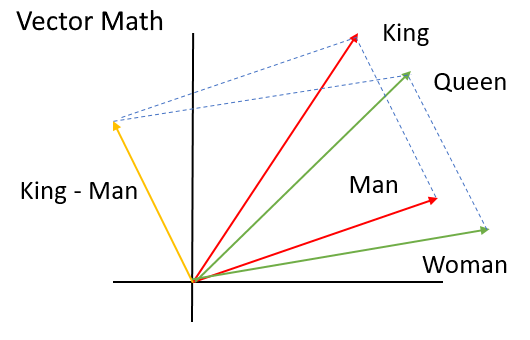

*fuente: https://blogs.mathworks.com/loren/2017/09/21/math-with-words-word-embeddings-with-matlab-and-text-analytics-toolbox/*|

Algunos ejemplos de relaciones que se podrían capturar serían por ejemplo que palabras como: *Paris, Teherán, Tokio, Canberra*  están relacionadas con la palabra capital, o *México, Estados Unidos, Canada* se relacionan con el término *Norte América*.  Por solo lo haremos mediante frecuencias, pero más adelante en el curso lo retomaremos mediane el uso de embeddings. 

Para un espacio vectorial de documentos, la dimensión de su espacio vectorial está dada por el tamaño del vocabulario $V$, es decir el número de palabras distintas en toda la colección de documentos. Por tanto la dimensión será $N=|V|$. Debido a la dificultad  de visualizar vectotres en de más de tres dimensiones, el hecho de que tanto TF como TF-IDF son vectores dispersos; se hace necesario proyectarlos mediante el uso de componenetes principales. Para nuestro caso usaremos la librería **TruncatedSVD**. 


In [34]:
train_s_norm.shape

(8000, 10962)

In [35]:
from sklearn.decomposition import TruncatedSVD
tsvd=TruncatedSVD(10, random_state=100)
tsvd.fit(train_s_norm)
X=tsvd.transform(train_s_norm)

In [36]:
X.shape

(8000, 10)

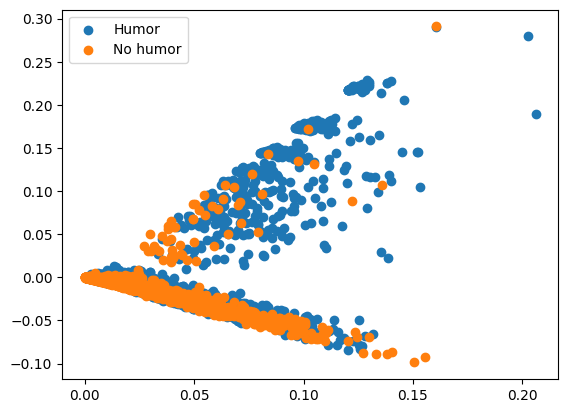

In [38]:

import  matplotlib.pyplot  as plt 
humor=np.where(train_df.is_humor==1)
no_humor=np.where(train_df.is_humor==0)
plt.scatter(X[:,0][humor],X[:,1][humor], label='Humor');
plt.scatter(X[:,0][no_humor],X[:,1][no_humor], label='No humor');
plt.legend()

In [39]:
import utilidades as ut

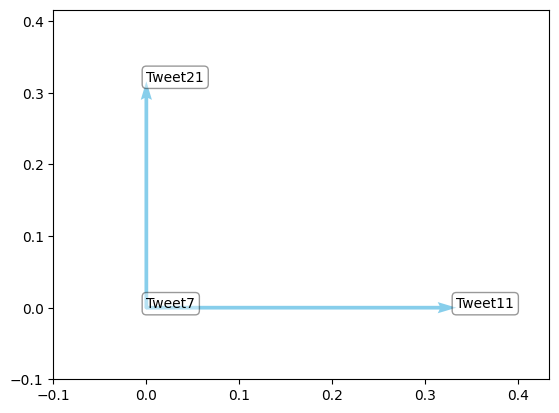

In [40]:
lista=[7,11,21]
ut.plotPCA(train_s_norm[lista],[f'Tweet{i}' for i in lista])

En un VMS, dod vectores son `similares` si tinen un ángulo similar. Opcionalmente, podría on no tener una magnitud similar. Una longitud similar implica frecuencias similares. Idealmente, nos gustaría que tanto el ángulo como la magnitud fueran aproximadamente iguales. Esto garantizaría que los documentos que representan cada vector probablemente traten de los mismo.

La similitud **coseno** es el coseno del ángulo ($\Theta$) entre dos vectores. Este puede ser calculado como el producto euclideano.

$$v_1 \cdot v_2= |v_1||v_2| \cos \Theta$$

$$\cos \Theta= \frac{v_1 \cdot v_2}{|v_1||v_2|}$$

La similitud de coseno toma valores entre 1 y -1, se calcula eficientemente utilizando el  producto escalar, y no requiere la evaluación de ninguna función trigonométrica.

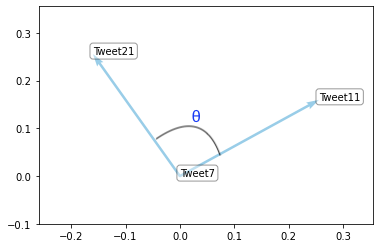

In [41]:
#Podemos definir la siguiente función
def coseno(x,y):
    if type(x)==sp.csr_matrix:
        norm=sp.linalg.norm(x) * sp.linalg.norm(y)
        sim=np.dot(x, y.T) / norm
        sim=sim[0,0]
    else:
        norm=(np.linalg.norm(x) * np.linalg.norm(y))
        sim=np.dot(x, y.T) / norm
    
    return sim

In [42]:
coseno(X[11,:],X[21,:])

0.1651672868235877

In [43]:
coseno(X[11,:],X[11,:])

1.0000000000000002

In [44]:
coseno(train_s_norm[11],train_s_norm[11])

1.0

In [45]:
dist=[coseno(train_s_norm[11],x) for x in train_s_norm]

In [46]:
coseno(train_s_norm[11],train_s_norm[1])

0.07647191129018725

In [47]:
np.mean(dist)

0.018408176893890866

Una similitud de 1 representa vectores normalizados idénticos con el mismo ángulo en todas las direcciónes. Un valor de 0 representa dos vectores que no comparten componentes, es decir son ortogonales en todas las dimensiones. Una similitud de coseno de -1 representa dos vectores que apuntan en direcciones opuestas. Lo último no puede suceder para vectores simples de conteo de palabras (TF o TF-IDF).

## La ley de Zipf

Está basada en una regla que gobierna de forma más o menos general las estadisticas basadas en conteo. A principios del siglo XX, el taquígrafo francés Jean-Baptiste Estoup notó un patrón en la frecuencia de las palabras en muchos documentos. En la década de 1930, el lingüista estadounidense George Kingsley Zipf intentó formalizar la observación de Estoup, y esta  finalmente se constituyo como la ley de Zipf:

`La ley de Zipf establece que, dado corpus de documentos en lenguaje natural, la frecuencia de cualquier palabra es inversamente proporcional a su rank en la tabla de frecuencias.`

La situación de proporcionalidad inversa se refiere a que un elemento de una lista rankeada por frecuencia, cada palabra aparecerá con una frecuencia vinculada explícitamente a su rank en la lista. Es decir, el primer elemento de la lista aparecerá dos veces más que el segundo y tres veces más que el tercero, por ejemplo. 

¿Como podemos observar esa situación con el vocabulario?

In [48]:
voc1_sort[:5]

[(229, 727), (149, 658), (50, 601), (128, 599), (161, 563)]

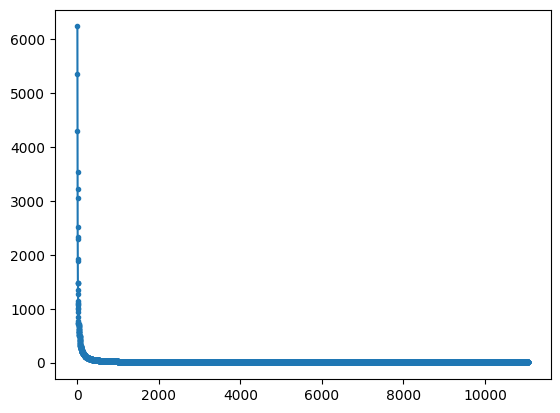

In [49]:
#Recordemos nuestro voc_sort
plt.plot([x[1] for x in voc_sort], marker='.')

Tracemos solo el top-100, top-20, top-10

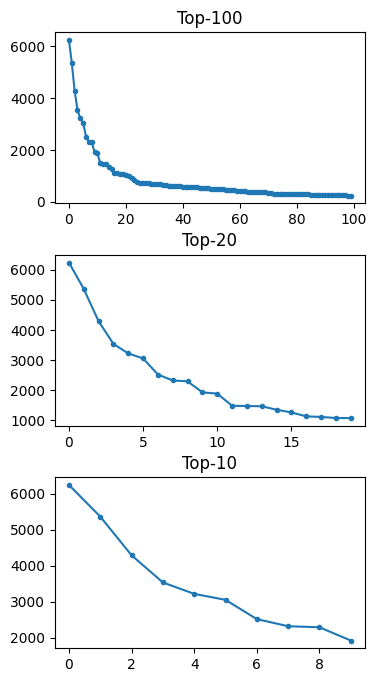

In [50]:
fig,axes=plt.subplots(3,1, figsize = (4,8))
for i,t in enumerate([100,20,10]): 
    axes[i].plot([x[1] for x in voc_sort[:t]], marker='.')
    axes[i].set_title(f"Top-{t}")
plt.subplots_adjust(hspace=0.3)

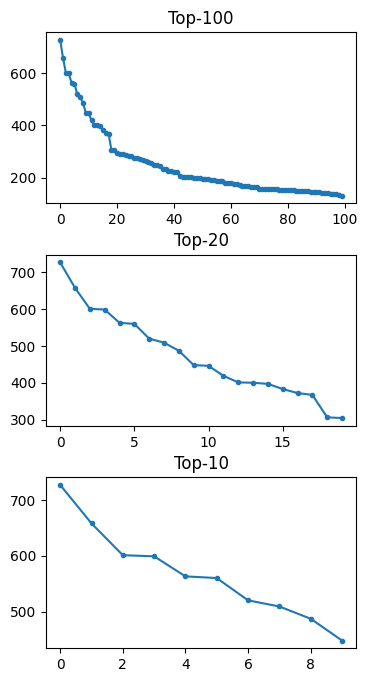

In [51]:
fig,axes=plt.subplots(3,1, figsize = (4,8))
for i,t in enumerate([100,20,10]): 
    axes[i].plot([x[1] for x in voc1_sort[:t]], marker='.')
    axes[i].set_title(f"Top-{t}")
plt.subplots_adjust(hspace=0.3)

En resumen, si rankea las palabras de un corpus por el número de ocurrencias y las enumera en orden descendente, encontrará que, para una muestra lo suficientemente grande, la primera palabra en esa lista clasificada tiende tener el doble de probabilidades de aparecer que la del segundo lugar; es cuatro veces más probable que la cuarta palabra de la lista y así sucecivamente. Es posible concluir que dado un corpus grande, es posible inferir estadísticamente qué tan probable es que una palabra determinada aparezca en cualquier documento de ese corpus.

<div class="alert alert-success">
<b>Ejercicio</b>:<br />
   Gráfique la curva de Zipf para el corpus de Bronw disponible en la bilbioteca nltk. Utilice Counter del modulo collection
</div>

In [55]:
#nltk.download('brown')
from nltk.corpus import brown
import string

In [56]:
len(brown.words()) # Total de palabras no está

1161192

In [58]:
lista_de_palabras = (x.lower() for x in brown.words() if x not in string.punctuation)

In [59]:
word_count=Counter(lista_de_palabras)

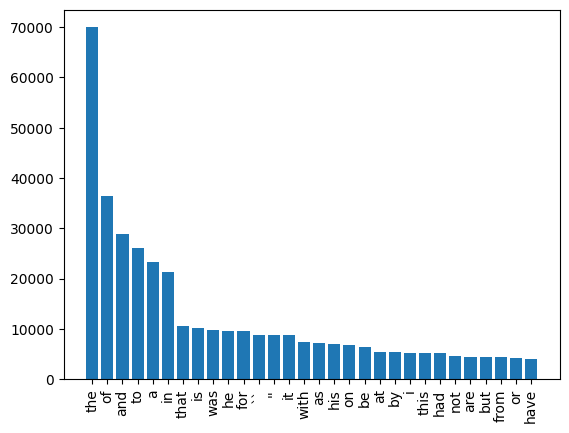

In [60]:
top=30
top_words=[x[0] for x in word_count.most_common(top)]
plt.bar(range(top),[x[1] for x in word_count.most_common(top)])
# Las palabras mas fecuentes en el corpus brown
plt.xticks(ticks=range(len(top_words)),labels=top_words,rotation='vertical'); 

### TF-IDF

Aun cuando el conteo de palabras es útil, por si solo no dice mucho sobre la importancia de cada palabra en el documento en relación con el resto de los documentos del corpus. Si pudiera descubrir esa información, podría comenzar a describir documentos de forma `global`  dentro del corpus. Suponga que tiene una colección de libros de historia. Es muy probable que la palabra `historia` ocurrirá muchas veces en cada libro (documento), dado que ya sabemos que son libros de historia, ese término no aporta información. Por otro lado términos como `lenguaje` o `electrónica` podrían no ser frecuentes  dentro del corpus, debido a lo anterior serían importantes para caracterizar esos documentos.

Para poder considerar la situción anterior, introduciremos el conceptos de frecuencia inversa de documentos (IDF), este concepto nos ayudará a aplicar Zipf para el análisis de los tópicos contenidos en un corpus. Note que tenemos dos tipos de frecuencia, está puede determinarse por documento o bien en todo el corpus.

Para ilustrar el uso de **TF-IDF** utilizaremos el corpus del contest *Spooky Author Identification*. Este corpus contiene fragamentos de los escritores de novelas de terror: `Edgar Allan Poe` (EAP), `Mary Shelley` (MWS) y `HP Lovecraft` (HPL), la tarea consiste en predecir el autor de cada uno de los fragmentos. 

In [61]:
# Obtenemos el conjunto de datos:
train_horror_df=pd.read_csv('data/horror/train.csv')
test_horror_df=pd.read_csv('data/horror/test.csv') 

In [62]:
train_horror_df.head() #la clase está dada por el autor

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [63]:
test_horror_df.head() # No conocemos las etiquetas

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [64]:
#Parametricemos un tokenizador 
tkh=Tokenizer()
tkh.fit(train_horror_df.text)

In [65]:
# Utilizaremos los siguientes dos textos:
doc_h1=train_horror_df.iloc[12952].text
doc_h2=train_horror_df.iloc[80].text

In [66]:
print(doc_h1)

Ye who are linked by the affectionate ties of nature, companions, friends, lovers fathers, who toil with joy for their offspring; women, who while gazing on the living forms of their children, forget the pains of maternity; children, who neither toil nor spin, but love and are loved "Oh, that death and sickness were banished from our earthly home that hatred, tyranny, and fear could no longer make their lair in the human heart that each man might find a brother in his fellow, and a nest of repose amid the wide plains of his inheritance that the source of tears were dry, and that lips might no longer form expressions of sorrow.


In [67]:
print(doc_h2)

My lieutenant, for instance, is a man of wonderful courage and enterprise; he is madly desirous of glory, or rather, to word my phrase more characteristically, of advancement in his profession.


In [68]:
#contamos el número de tokens en cada documento
doc_h1_tokens=tkh.tokenize(doc_h1)
doc_h2_tokens=tkh.tokenize(doc_h2)
doc_h1_total=len(doc_h1_tokens)
doc_h2_total=len(doc_h2_tokens)

In [69]:
doc_h1_tokens[:10]

['ye',
 'who',
 'are',
 'linked',
 'by',
 'the',
 'affectionate',
 'ties',
 'of',
 'nature']

A partir de los documentos tokenizados, computemos la frecuencia de normalizada de `man` y guardemosla en diccionario para cada documento:

In [70]:
doc1_tf,doc2_tf={},{}
doc1_frec, doc2_frec=Counter(doc_h1_tokens),Counter(doc_h2_tokens)

In [71]:
doc2_frec['man']

1

In [72]:
doc1_tf['man']=doc1_frec['man']/doc_h1_total
doc2_tf['man']=doc2_frec['man']/doc_h2_total

In [73]:
print(f"Fecuencia de la palabra man en doc1: {doc1_tf['man']}")
print(f"Fecuencia de la palabra man en doc2: {doc2_tf['man']}")

Fecuencia de la palabra man en doc1: 0.008849557522123894
Fecuencia de la palabra man en doc2: 0.03225806451612903


De acuerdo al frecuencia el termino `man` es casi 4 veces más importante en *doc_h2* que el en *doc_h1*. Pero la frecuencia no estaría capturando la correctamente la relevacia de las palabras. Considere ahora que la palabra `and`.

In [75]:
doc1_tf['and']=doc1_frec['and']/doc_h1_total
doc2_tf['and']=doc2_frec['and']/doc_h2_total
print(f"Fecuencia de la palabra and en doc1: {doc1_tf['and']}")
print(f"Fecuencia de la palabra and en doc2: {doc2_tf['and']}")

Fecuencia de la palabra and en doc1: 0.04424778761061947
Fecuencia de la palabra and en doc2: 0.03225806451612903


Con los valores obtenidos tendríamos que `and` es tan importante en el *doc2* como lo es la palabra `man`, y en el caso de *doc1* `and` es 5 veces más descriptiva!. Sin embargo, es evidente que la palabra `and` no aporta información del contenido del texto. 

Con la frecuencia inversas (IDF) estaríamos identificando que tan extraño es que un termino determinado aparezca en un documento. Si un token se repite muchas veces en un documento, pero es poco frecuente en el restodel corpus, se podría asumir que es importante específicamente para ese documento.

La frecuencia inversa de un término es la relación entre el número total de documentos y el número de documentos que contienen ese token. En el caso de `and` y `man` el valor sería el mismo para ambos:

- 2 documentos / 2 documentos que contiene `and` = 1
- 2 documentos / 2 documentos que contiene `man` = 1

Si consideramos el token `children`

In [76]:
doc1_tf['children']=doc1_frec['children']/doc_h1_total
doc2_tf['children']=doc2_frec['children']/doc_h2_total
print(f"Fecuencia de la palabra children en doc1: {doc1_tf['children']}")
print(f"Fecuencia de la palabra children en doc2: {doc2_tf['children']}")

Fecuencia de la palabra children en doc1: 0.017699115044247787
Fecuencia de la palabra children en doc2: 0.0


Ahora calculemos idf para todos los tres terminos. Primero calculemos el número de documentos donde aparece cada término

In [77]:
doc_term_count={}
for token in set(doc_h1_tokens+doc_h2_tokens): # Vocabulario
    for doc in [doc_h1_tokens, doc_h2_tokens]: # todos los documentos
         if token in doc: # Aparece en el documento? 
            doc_term_count[token]=doc_term_count.get(token,0)+1

In [78]:
doc_term_count['the'] #en cuantos documentos aparece and

1

In [79]:
# Calculemos IDF
doc1_idf={}
doc2_idf={}
for token in ['and','man','children']:
    doc1_idf[token]=2/doc_term_count[token]
    doc2_idf[token]=2/doc_term_count[token]

In [80]:
doc2_idf.keys()

dict_keys(['and', 'man', 'children'])

Ahora podemos calcular TF-IDF como $\mathit{tf}*\mathit{idf}$.

In [81]:
doc1_tfidf={}
doc2_tfidf={}
for token in ['and','man','children']:
        doc1_tfidf[token]=doc1_tf[token]*doc1_idf[token]
        doc2_tfidf[token]=doc2_tf[token]*doc2_idf[token]

In [82]:
doc1_tfidf

{'and': 0.04424778761061947,
 'man': 0.008849557522123894,
 'children': 0.035398230088495575}

In [83]:
doc2_tfidf

{'and': 0.03225806451612903, 'man': 0.03225806451612903, 'children': 0.0}

### TF-IDF y Zipf

Supongamos que se tiene un corpus de 1 millón de documentos, y que la palabra `gato` aparece en un solo. Entonces:

$\mathit{idf}_{\mathit{gato}}=\frac{1000000}{1}=1000000$

Ahora, si tenemos la palabra `vaca` que aparece en 10 documentos por ejemplo:

$\mathit{idf}_{\mathit{vaca}}=\frac{1000000}{10}=100000$


Si utilizamos Zipf sobre IDF nos diría que existe una diferencia muy grande, cuando en realidad son relativamente igual de probables grande. La ley de Zipf nos dice que cuando se comparan las frecuencias de dos palabras, como `gato` y `vaca`, incluso un número similar de veces, la palabra más frecuente tendrá una frecuencia exponencialmente más alta que la menos frecuente. 

Es posible remediar esto escalando todas las frecuencias de palabras (y frecuencias de documentos) con la función $\log()$ (i.e. la función inversa de un exponencial). Esto asegura que palabras que tienen frecuencias similares no difieran exponencialmente en frecuencia. Esto abona que la distribución de frecuencias de palabras usando TF-IDF sea más uniforme. Por lo tanto, IDF debe definidad el logaritmo de la probabilidad original de que aparezca en uno de los documentos (lo mismo para la frecuencia). 

La base del logaritmo no es importante, ya que solo quiere que la distribución de frecuencia sea uniforme, no escalarla dentro de un rango particular. Por ejemplo si utilizamos logaritmo base 10 tendremos:


$\mathit{idf}_{\mathit{gato}}=\log(\frac{1000000}{1})=6$


$\mathit{idf}_{\mathit{vaca}}=\log(\frac{1000000}{10})=5$

lo anterior resulta en un pesado más apropiado.


Sumarizando tenemos:

$$\mathit{tf}(t,d)=\frac{\mathit{count}(t)}{\mathit{count}(t)}$$ 

$$\mathit{idf}(t,D)=\log\frac{\mathit{numero\_de\_documentos}}{\mathit{numero\_de\_documentos\_que\_contienen\_}t}$$ 

$$\mathit{tfidf}(t,d,D)=\mathit{tf}(t,d)*\mathit{idf}(t,D)$$

donde $t$ representa un token, $d$ un documento y $D$ un corpus de documentos.

Así, cuantas más veces aparezca una palabra en un documento, TF aumentará TF-IDF aumentan. Al mismo tiempo, a medida que aumenta el número de documentos que contienen esa palabra, el IDF  disminuirá y TF-IDF también lo hará. Lo que hace TF-IDF es dar un pesado que ayuda a relacionar un término con un documento específico en un corpus, asignando un valor numérico a la importancia de esa palabra en el documento dado, dado su uso dentro de todo el corpus.

In [84]:
tkh=Tokenizer(remove_stop_words=True)
tkh.fit(train_horror_df.text)

In [97]:
test=tkh.transform(test_horror_df.text)

In [98]:
train= tkh.transform(train_horror_df.text)

In [ ]:
test = tkh.tf_idf(test_horror_df.text)

In [99]:
from sklearn.preprocessing import LabelEncoder
l=train_horror_df.author
le=LabelEncoder()
le.fit(l)

LabelEncoder()

In [100]:
y=le.transform(l)

In [101]:
from sklearn.svm import SVC, LinearSVC

In [102]:
clf=SVC(kernel='linear')
clf.fit(train,y)

SVC(kernel='linear')

In [103]:
clf1=LinearSVC()
clf1.fit(train,y)

/home/job/python3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [104]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

In [105]:
scores = cross_val_score(clf1, train, y, cv=5, scoring='f1_macro')

/home/job/python3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/job/python3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/job/python3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/job/python3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/job/python3/lib/python3.11/site-packag

In [106]:
scores

array([0.78072472, 0.77019538, 0.78114929, 0.78147769, 0.789856  ])

In [107]:
yt=clf1.decision_function(test)

In [108]:
y

array([0, 1, 0, ..., 0, 0, 1])

## Librería TF-IDF

La libreía **scikit-sklearn**  Ya cueta con una librería que permite general VSM tf-idf. Está librería tiene una amplia gama de parámetros que pueden ajustarse, los cuales vamos optimizar mediante diferentes técnicas de optimización. Puede consultar todos los parámetros del vectorizador en:

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
corpus=train_df.text # definimos el corpus

In [ ]:
vectorizer = TfidfVectorizer()
modelo = vectorizer.fit(corpus) # Entrenamos el modelo con los parámetros default

In [ ]:
trainv=vectorizer.transform(corpus)
testv=vectorizer.transform(test_df.text) # Transformamos los datos con el modelo generdado

In [ ]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(trainv,train_df.is_humor)
yt=test_df.is_humor
yp=clf.predict(testv)

In [ ]:
print(f'f1:{f1(yt,yp)} Accuracy:{acc(yt,yp)}') 